In [1]:
import numpy as np
import os
import re
import random

import tensorflow as tf

target_shape = (96, 96)
BATCH_SIZE = 190
images_path = os.getcwd() + "\Dataset"

In [2]:
import cv2

def preprocess_image(filename):
    """
    Load the specified file as a BMP image, preprocess it and
    resize it to the target shape.
    """
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_shape)
    img = np.expand_dims(img, axis=-1)
    img = img.astype(np.float32) /255.
    return img

In [3]:
from sklearn.model_selection import train_test_split

dicImages = {}
dataset_x = []; dataset_y = []
for dirs in os.listdir(images_path):
    for f in os.listdir(images_path+'\\'+dirs):
        if(dirs == 'Real'):
            dataset_x.append(images_path+'\\'+dirs+'\\'+f)
        else:
            dataset_y.append(images_path+'\\'+dirs+'\\'+f)
    
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
    
x_train, x_val = train_test_split(dataset_x, test_size=0.1)


print(dataset_x.shape, dataset_y.shape)
print(x_train.shape)
print(x_val.shape)

del(dataset_x)

(6000,) (49270,)
(5400,)
(600,)


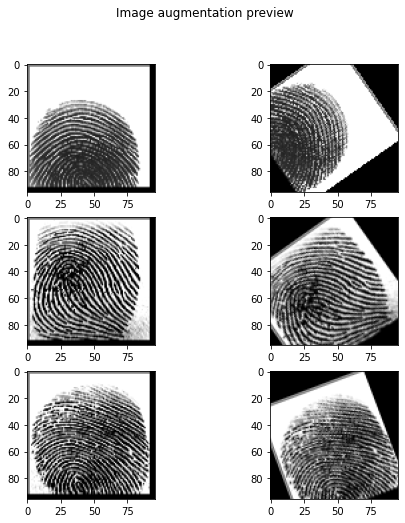

In [4]:
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Preview of image augmentation:

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-90, 90),
        shear=[0, 1],
        order=[0, 1],
    )
], random_order=True)
    
tabClean = []; tabImg = []
for i in range (3):
    tabClean.append(preprocess_image(random.choice(x_train)))
    tabImg.append(tabClean[i])

tabImg = seq.augment_images(tabImg)

fig, axs = plt.subplots(len(tabImg), 2)
fig.suptitle('Image augmentation preview')
fig.set_figheight(8); fig.set_figwidth(8)
for i in range(len(tabImg)):
    axs[i, 0].imshow(tabClean[i], cmap='gray')
    axs[i, 1].imshow(tabImg[i], cmap='gray')

In [5]:
from sklearn.utils import shuffle

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, x2, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.x2 = x2
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch_tmp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = []
        for f in x1_batch_tmp: x1_batch.append(preprocess_image(f))
        x1_batch = np.array(x1_batch)
        
        x2_batch = []
        
        if random.random() > 0.9:
            #Take clean image then augment it
            x2_batch = x1_batch

            # augmentation
            if self.shuffle:
                seq = iaa.Sequential([
                    iaa.GaussianBlur(sigma=(0, 0.5)),
                    iaa.Affine(
                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-90, 90),
                        order=[0, 1]
                    )
                ], random_order=True)

                x2_batch = seq.augment_images(x2_batch)
        else:
            #Take an already transformed image
            for i in range(len(x1_batch_tmp)):
                tabListImg = []
                for f2 in self.x2:
                    if(str(x1_batch_tmp[i][74:-4]) in str(f2[70:-4])): tabListImg.append(f2)
                x2_batch.append(preprocess_image(random.choice(tabListImg)))
            x2_batch = np.array(x2_batch)
                
        return x2_batch, x1_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x = shuffle(self.x)

In [6]:
train_gen = DataGenerator(x_train, dataset_y, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DataGenerator(x_val, dataset_y, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(input)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def get_autoencoder():
    inputs = layers.Input(target_shape + (1,))

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net-like")
    model.summary()
    return model

model = get_autoencoder()

Model: "U-Net-like"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   36928       batch_normalization[0][0]        
_________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer = 'RMSprop',
    loss='mean_squared_error')

history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=15)

In [ ]:
model.save_weights('autoencoder_weight.h5')

In [8]:
model.load_weights('autoencoder_weight.h5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(15)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

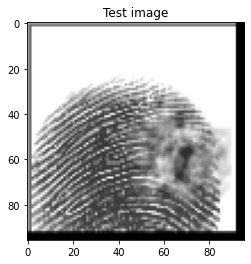

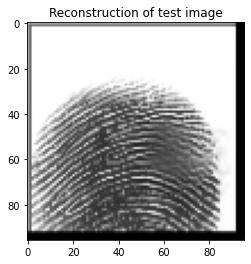

In [17]:
randomImage = preprocess_image(random.choice(dataset_y))
randomImage = np.expand_dims(randomImage, axis=0)
pred = model.predict(randomImage)

plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.title('Test image')
plt.imshow(randomImage[0], cmap='gray')
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1,2,2)
plt.title('Reconstruction of test image')
plt.imshow(pred[0], cmap='gray')
plt.show()